## Movie Review Dataset, Word2Vec, Topic Modeling, and Sentiment Classification
### Part 1. Word2Vec
We will use parts 1 thru 4 of the blog https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words as reference for Part I. The steps we will take for this part are as follows:

a. Create vector representations for each movie post in your training set by training word2vec with context=5, embedding dimension=100, min_words=40. We’ll call the collection of these representations Z1.

b. Create vector representations for each movie post in your training set by loading the pretrained Google word2vec model. We’ll call the collection of thes representations Z2.

c. With k=10, do k-means clustering on each set Z1, Z2. Print a table of the words in each cluster for Z1 and for Z2.

d. Featurize the training and test reviews in Z1, Z2 to produce design matrices X1, X2 as described in part 3 of the blog series. Basically, each review is converted into a bag of centroids feature vector with each vector component representing
the count of the number of words in that review that belong in that component’s cluster.

e. Save X1,X2 for Part III.

First, we read in the data with pandas. We will also use unlabeledTrain.tsv, which contains 50,000 additional reviews with no labels. Since Word2Vec can learn from unlabeled data, these extra 50,000 reviews can now be used in addition to the labeled training data.

In [1]:
import pandas as pd

# Here, "header=0" indicates that the first line of the file contains column names,
# "delimiter=\t" indicates that the fields are separated by tabs, and 
# quoting=3 tells Python to ignore doubled quotes, otherwise you may encounter errors trying to read the file.
train = pd.read_csv( "labeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )
unlabeled_train = pd.read_csv( "unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )
test = pd.read_csv( "testData.tsv", header=0, delimiter="\t", quoting=3 )

# Verify the number of reviews that were read (100,000 in total)
print ("Read {} labeled train reviews, {} labeled test reviews, and {} unlabeled reviews\n".format(
        train["review"].size, test["review"].size, unlabeled_train["review"].size))

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews



Let's check the columns of each data set to confirm that the unlabeled training data, unlike the labeled training data, is missing the sentiment scores as expected.

In [2]:
print(train.columns.values)
print(test.columns.values)
print(unlabeled_train.columns.values)

['id' 'sentiment' 'review']
['id' 'review']
['id' 'review']


In [3]:
print(train.shape)  #expected (rows, cols) value of (25000, 3)
print(test.shape)   #expected (rows, cols) value of (25000, 2)
print(unlabeled_train.shape)   #expected (rows, cols) value of (50000, 2) since this is unlabeled training data

(25000, 3)
(25000, 2)
(50000, 2)


We will now write functions to clean up the data. Since we'll be using Word2Vec, it is better not to remove stopwords because the algorithm relies on the broader context of the sentence in order to produce high-quality word vectors. So, we will make stopword removal optional below.

In [4]:
# Import various modules for string cleaning
from bs4 import BeautifulSoup
import re #regular expressions
from nltk.corpus import stopwords

def review_to_wordlist( review, remove_stopwords=False, remove_nonletters=True ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
#     review_text = BeautifulSoup(review).get_text()
    review_text = BeautifulSoup(review, "html.parser").get_text()
    #  
    # 2. Remove non-letters depending on parameter above
    if remove_nonletters:
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

Next, we'll use NLTK's punkt tokenizer for sentence splitting. Make sure to have NLTK installed and if necessary, use nltk.download() to download punkt.

In [5]:
# Download the punkt tokenizer for sentence splitting
import nltk.data
# nltk.download()

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_wordlist( raw_sentence, \
              remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

Now we can invoke the above functions to prepare our data for input to Word2Vec. There may be some warnings outputted during this process, which can be ignored.

In [6]:
sentences = []  # Initialize an empty list of sentences

# A minor detail to note is the difference between the "+=" and "append" when it comes to Python lists. 
# In many applications the two are interchangeable, but here they are not. 
# If you are appending a list of lists to another list of lists, "append" will only append 
# the first list; you need to use "+=" in order to join all of the lists at once.
print ("Parsing sentences from training set")
for review in train["review"]:
    sentences += review_to_sentences(review, tokenizer)

print ("Parsing sentences from unlabeled set")
for review in unlabeled_train["review"]:
    sentences += review_to_sentences(review, tokenizer)

Parsing sentences from training set


D:\Program_Files_Nospace\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
D:\Program_Files_Nospace\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
D:\Program_Files_Nospace\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "http://www.happierabroad.com"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Parsing sentences from unlabeled set


D:\Program_Files_Nospace\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "http://www.archive.org/details/LovefromaStranger"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
D:\Program_Files_Nospace\Anaconda3\lib\site-packages\bs4\__init__.py:282: UserWarning: "http://www.loosechangeguide.com/LooseChangeGuide.html"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
D:\Program_Files_Nospace\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'... ...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup

Let us now take a look at the some of the output:

In [7]:
# Check how many sentences we have in total
print (len(sentences))

# Print some example sentences parsed in list format.
print (sentences[0])
print (sentences[1])

795538
['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'with', 'mj', 'i', 've', 'started', 'listening', 'to', 'his', 'music', 'watching', 'the', 'odd', 'documentary', 'here', 'and', 'there', 'watched', 'the', 'wiz', 'and', 'watched', 'moonwalker', 'again']
['maybe', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into', 'this', 'guy', 'who', 'i', 'thought', 'was', 'really', 'cool', 'in', 'the', 'eighties', 'just', 'to', 'maybe', 'make', 'up', 'my', 'mind', 'whether', 'he', 'is', 'guilty', 'or', 'innocent']


With the list of nicely parsed sentences, we're ready to train the Word2Vec model. We will try using context=5, embedding dimension=100, min_words=40. 

Be sure to have gensim module installed.

Some notes on all parameters below for informative purposes:

* Architecture: Architecture options are skip-gram (default) or continuous bag of words.
* Training algorithm: Hierarchical softmax (default) or negative sampling.
* Downsampling of frequent words: The Google documentation recommends values between .00001 and .001.
* Word vector dimensionality: More features result in longer runtimes, and often, but not always, result in better models.
* Context / window size: How many words of context should the training algorithm take into account? (more is better, up to a point)
* Worker threads: Number of parallel processes to run. This is computer-specific, but between 4 and 6 should work on most systems.
* Minimum word count: This helps limit the size of the vocabulary to meaningful words. Any word that does not occur at least this many times across all documents is ignored. Reasonable values could be between 10 and 100.

In [8]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
embedding_dimension = 100    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 5          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=embedding_dimension, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "100features_40minwords_5context"


D:\Program_Files_Nospace\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
2017-12-11 23:45:17,319 : INFO : 'pattern' package not found; tag filters are not available for English
2017-12-11 23:45:17,404 : INFO : collecting all words and their counts
2017-12-11 23:45:17,404 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-12-11 23:45:17,509 : INFO : PROGRESS: at sentence #10000, processed 225803 words, keeping 17776 word types
2017-12-11 23:45:17,584 : INFO : PROGRESS: at sentence #20000, processed 451892 words, keeping 24948 word types


Training model...


2017-12-11 23:45:17,648 : INFO : PROGRESS: at sentence #30000, processed 671314 words, keeping 30034 word types
2017-12-11 23:45:17,753 : INFO : PROGRESS: at sentence #40000, processed 897814 words, keeping 34348 word types
2017-12-11 23:45:17,818 : INFO : PROGRESS: at sentence #50000, processed 1116962 words, keeping 37761 word types
2017-12-11 23:45:17,918 : INFO : PROGRESS: at sentence #60000, processed 1338403 words, keeping 40723 word types
2017-12-11 23:45:17,968 : INFO : PROGRESS: at sentence #70000, processed 1561579 words, keeping 43333 word types
2017-12-11 23:45:18,066 : INFO : PROGRESS: at sentence #80000, processed 1780886 words, keeping 45714 word types
2017-12-11 23:45:18,137 : INFO : PROGRESS: at sentence #90000, processed 2004995 words, keeping 48135 word types
2017-12-11 23:45:18,215 : INFO : PROGRESS: at sentence #100000, processed 2226966 words, keeping 50207 word types
2017-12-11 23:45:18,269 : INFO : PROGRESS: at sentence #110000, processed 2446580 words, keeping 

2017-12-11 23:45:22,403 : INFO : PROGRESS: at sentence #750000, processed 16771399 words, keeping 120295 word types
2017-12-11 23:45:22,470 : INFO : PROGRESS: at sentence #760000, processed 16990803 words, keeping 120930 word types
2017-12-11 23:45:22,536 : INFO : PROGRESS: at sentence #770000, processed 17217940 words, keeping 121703 word types
2017-12-11 23:45:22,604 : INFO : PROGRESS: at sentence #780000, processed 17448086 words, keeping 122402 word types
2017-12-11 23:45:22,674 : INFO : PROGRESS: at sentence #790000, processed 17675162 words, keeping 123066 word types
2017-12-11 23:45:22,718 : INFO : collected 123504 word types from a corpus of 17798263 raw words and 795538 sentences
2017-12-11 23:45:22,719 : INFO : Loading a fresh vocabulary
2017-12-11 23:45:22,807 : INFO : min_count=40 retains 16490 unique words (13% of original 123504, drops 107014)
2017-12-11 23:45:22,808 : INFO : min_count=40 leaves 17239118 word corpus (96% of original 17798263, drops 559145)
2017-12-11 23:4

2017-12-11 23:46:24,773 : INFO : training on 88991315 raw words (63743061 effective words) took 61.4s, 1037819 effective words/s
2017-12-11 23:46:24,775 : INFO : precomputing L2-norms of word weight vectors


Now that we have the model, we can optionally save it so that it can be loaded for later use. Let's try it.

In [9]:
# model.save(model_name) # may be deprecated. See https://groups.google.com/forum/embed/#!topic/gensim/hlYgjqEVocw
# See https://groups.google.com/forum/embed/#!topic/gensim/hlYgjqEVocw for why we use the below method to save
model.wv.save_word2vec_format(model_name)

2017-12-11 23:46:24,914 : INFO : storing 16490x100 projection weights into 100features_40minwords_5context


We will name this model Z1. While we could simply rename the model, let's see whether we can load the saved model under this name instead.

In [10]:
# We will re-Load the model that we created above under a different name, and assign it the name Z1
# (just to show that the model_name = "100features_40minwords_5context" that we gave to the model above matters)
from gensim import models

# The below may be deprecated
# model = models.Word2Vec.load("100features_40minwords_5context") # deprecated?

# See https://groups.google.com/forum/embed/#!topic/gensim/hlYgjqEVocw for the updated way to load model
Z1 = models.KeyedVectors.load_word2vec_format(model_name)
print(Z1)

2017-12-11 23:46:25,701 : INFO : loading projection weights from 100features_40minwords_5context
2017-12-11 23:46:27,771 : INFO : loaded (16490, 100) matrix from 100features_40minwords_5context


Now that we have the Word2Vec model Z1, we will also load another (this time pre-trained) Google word2vec model, downloadable from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit, and name the model Z2 for comparison.

(Be sure you have downloaded the file before running the below code.)

In [11]:
# Z2 = models.Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) # deprecated
Z2 = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

2017-12-11 23:46:27,782 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin
2017-12-11 23:47:14,187 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin


To access the actual word vectors in each model (Z1 and Z2), we can use the .syn0 attribute. Let's try it.

In [12]:
print(type(Z1.syn0))
print(Z1.syn0)

print(type(Z2.syn0))
print(Z2.syn0)

<class 'numpy.ndarray'>
[[ 0.10383    -0.193166   -0.060637   ..., -0.093661    0.10813    -0.013873  ]
 [-0.047408   -0.190431    0.031611   ..., -0.112418   -0.104364   -0.001224  ]
 [-0.122563   -0.018094   -0.076372   ..., -0.10041     0.170076   -0.054085  ]
 ..., 
 [-0.014105    0.085763    0.085873   ..., -0.080833   -0.088632    0.050441  ]
 [-0.089579   -0.169478    0.068326   ..., -0.063105   -0.157755   -0.034911  ]
 [-0.014685    0.08064     0.19272199 ..., -0.006419    0.104657   -0.097061  ]]
<class 'numpy.ndarray'>
[[  1.12915039e-03  -8.96453857e-04   3.18527222e-04 ...,  -1.56402588e-03
   -1.23023987e-04  -8.63075256e-05]
 [  7.03125000e-02   8.69140625e-02   8.78906250e-02 ...,  -4.76074219e-02
    1.44653320e-02  -6.25000000e-02]
 [ -1.17797852e-02  -4.73632812e-02   4.46777344e-02 ...,   7.12890625e-02
   -3.49121094e-02   2.41699219e-02]
 ..., 
 [ -1.96533203e-02  -9.08203125e-02  -1.94091797e-02 ...,  -1.63574219e-02
   -1.34277344e-02   4.66308594e-02]
 [  3.271

Let's also compare the shapes of Z1 and Z2. The number of rows in syn0 is the number of words in the model's vocabulary, and the number of columns corresponds to the size of the feature vector. 

Since we set embedding_dimension=100 and minimum word count to 40 when training Z1, this gave us a total vocabulary of 16,490 words with 100 feature dimensions apiece for Z1. On the other hand, we can see that Z2, the pre-trained model, has a lot more word count (3,000,000). Also, Z2 has more feature dimensions (300) per each word vector.

In [13]:
print(Z1.syn0.shape)
print(Z2.syn0.shape)
print(type(Z1.syn0))

(16490, 100)
(3000000, 300)
<class 'numpy.ndarray'>


Individual word vectors can be accessed in the following way:

In [14]:
print(Z1['flower'].shape)
print(Z2['flower'].shape)
print(Z1["flower"])
print(Z2["flower"])

(100,)
(300,)
[-0.05361    -0.23726501  0.029005    0.142961    0.069741   -0.246251
 -0.147167   -0.003953   -0.058661   -0.109174    0.033523    0.077374
  0.063918   -0.017038    0.094818    0.074536    0.082149   -0.103084
 -0.024684    0.113354   -0.127057    0.101311    0.014492    0.093026
 -0.237022    0.091341    0.023944   -0.087654    0.095167   -0.082826
  0.02853     0.035607    0.112977   -0.019871    0.150985    0.166881
  0.035903    0.036964   -0.134223   -0.071485   -0.048275   -0.061325
  0.068068    0.049736    0.076065   -0.028115   -0.029241   -0.131771
  0.14679199  0.018566    0.106289   -0.136793    0.20285299 -0.00585
  0.047124    0.07448    -0.027861   -0.002188   -0.111542   -0.048282
 -0.123842    0.14306299 -0.007149    0.055043    0.020521   -0.00875
  0.122092    0.13054299  0.15997     0.128665    0.039715   -0.048452
  0.054654    0.073006    0.014196   -0.14986999 -0.167294    0.123016
 -0.090545    0.041684   -0.02138     0.026111    0.049442   -0.1

We can also access all the vocabulary words in the model by invoking model.vocab or model.index2word as shown below.
If we want to check whether a specific word is in the model, lookup is pretty simple.

Note that model.index2word contains a list of words in the same corresponding order as model.syn0, the word vectors.

In [15]:
print(type(Z1.index2word))
print(type(Z1.vocab))

print(Z1.index2word[:10])
print('queen' in Z1.vocab.keys())

print(Z2.index2word[:10])
print('queen' in Z2.vocab.keys())

<class 'list'>
<class 'dict'>
['the', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this']
True
['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said']
True


Just for demonstrative purposes, here are some built-in methods we can run on the models.

In [16]:
# Prints the top 10 (by default) words that the model deems most similar to the given word parameter. Compare Z1 and Z2.
print(Z1.most_similar("awful"))
print(Z1.most_similar("great"))
print(Z2.most_similar("awful"))
print(Z2.most_similar("great"))

# Prints the top 6 (notice the topn=6 parameter) words that are at once similar to the list of positive parameter words,
# and dissimilar to the list of negative parameter words.
print(Z1.most_similar(positive=['man', 'wealthy'], negative=['woman', 'poor'], topn=6))
print(Z1.most_similar(positive=['woman', 'wealthy'], negative=['man', 'poor'], topn=6))
print(Z2.most_similar(positive=['man', 'wealthy'], negative=['woman', 'poor'], topn=6))
print(Z2.most_similar(positive=['woman', 'wealthy'], negative=['man', 'poor'], topn=6))

# Prints the one word out of the parameter list that is most dissimilar to the others.
print(Z1.doesnt_match(["man", "woman", "child", "kitchen"]))
print(Z1.doesnt_match("france england germany berlin".split()))
print(Z1.doesnt_match("paris berlin london austria".split()))
print(Z2.doesnt_match(["man", "woman", "child", "kitchen"]))
print(Z2.doesnt_match("france england germany berlin".split()))
print(Z2.doesnt_match("paris berlin london austria".split()))

2017-12-11 23:47:21,962 : INFO : precomputing L2-norms of word weight vectors
2017-12-11 23:47:27,172 : INFO : precomputing L2-norms of word weight vectors


[('horrible', 0.8357001543045044), ('terrible', 0.8328368663787842), ('atrocious', 0.8239460587501526), ('horrendous', 0.7926422357559204), ('abysmal', 0.7923781275749207), ('dreadful', 0.791000485420227), ('horrid', 0.7667386531829834), ('appalling', 0.7579952478408813), ('laughable', 0.72221440076828), ('bad', 0.7015225291252136)]
[('wonderful', 0.8436251878738403), ('fantastic', 0.8372352123260498), ('terrific', 0.8307784795761108), ('fine', 0.7884525060653687), ('good', 0.7661899328231812), ('superb', 0.7514241933822632), ('brilliant', 0.7448533773422241), ('marvelous', 0.7355630993843079), ('fabulous', 0.6920579671859741), ('excellent', 0.6858861446380615)]
[('horrible', 0.7597668170928955), ('terrible', 0.7478911876678467), ('dreadful', 0.7218177318572998), ('horrendous', 0.6970030069351196), ('horrid', 0.6720176935195923), ('atrocious', 0.6626646518707275), ('ugly', 0.6236302852630615), ('lousy', 0.6135217547416687), ('god_awful', 0.6096222400665283), ('abysmal', 0.6076565384864

Now that we have the word2vec models Z1 and Z2, we will use K-Means clustering to exploit the semantic similarity of words. Grouping vectors in this way is known as "vector quantization."

In K-Means, the one parameter we need to set is "K," or the number of clusters. How should we decide how many clusters to create? Many clusters of small sizes (with relatively few words per cluster) tend to give better results than using a few clusters of large sizes (with a lot of words per cluster).

For our experiment, we will set num_clusters for each Word2Vec model to equal the following:

(num of words in model) / 5

We begin by defining a method to run the clustering.

In [17]:
from sklearn.cluster import KMeans
import time

def k_means_cluster(num_clusters, word_vectors):
    start = time.time() # Start time

    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans( n_clusters = num_clusters )

    # run clustering
    print("Running .fit_predict()...")
    idx = kmeans_clustering.fit_predict( word_vectors )

    # Get the end time and print how long the process took
    end = time.time()
    elapsed = end - start
    print ("Time taken for K Means clustering: ", elapsed, "seconds.")
    return idx

Before we invoke the above method, we will first reduce the size of word vectors in Z2 by filtering out the words in Z2 that are not contained in Z1. This is for efficiency, at the possible cost of losing out on some accuracy when predicting using the Z2 model.

In [18]:
# Let's filter out the words from Z2 that are not in Z1 for efficiency

# Helper method to see if two vectors are equal or not
def areEqual(v1, v2):
    if len(v1) != len(v2):
        return False
    for i in range(len(v1)):
        if v1[i] != v2[i]:
            return False
    return True

# This uses Z2[word] to look up corresponding vector for a word instead of using syn0 and index2word as we did above
z1_vocab_keys_set = set(Z1.vocab.keys())  # convert set of words in Z1 into a set for efficiency when performing lookup
z2_index2word_list = Z2.index2word        # this is a list of words in Z2 corresponding to Z2's word vectors (Z2.syn0).

# Initialize filtered lists for vectors (syn0) and words themselves (index2word)
z2_syn0_filtered = []
z2_index2word_filtered = []

# Go thru each word in Z2, and add only filtered words to theh above lists.
for i in range(len(z2_index2word_list)):
    word = z2_index2word_list[i]
    if word in z1_vocab_keys_set:  # Is this word contained in Z1? If so add to filtered list
        z2_corresponding_vector = Z2[word]           # this is one way to look up corresponding word vector
        z2_corresponding_vector_doublecheck = Z2.syn0[i]  # this is a second way
        # for sanity, let's check the two vectors obtained above are the same
        assert areEqual(z2_corresponding_vector, z2_corresponding_vector_doublecheck)
        z2_syn0_filtered.append(z2_corresponding_vector) # add the word vector to list
        z2_index2word_filtered.append(word)              # add the corresponding word string to list

# Testing. The length below should be equal.
print(len(z2_syn0_filtered))
print(len(z2_index2word_filtered))

15181
15181


Now that we have a filtered list of words and word vectors for Z2, let's do some sanity checks...

In [19]:
# Remember, Z2.syn0 is a list of word vectors. Z2.index2word is a list of words corresponding to those vectors.
# z2_syn0_filtered is a filtered version of Z2.syn0, containing only word vectors that exist in Z1.
# z2_index2word_filtered is a filterd version of Z2.index2word, containing only words that exist in Z1.

# Notice that z2_index2word_filtered maintains the same word ordering as Z2.index2word, except the former has some words
# filtered out and is thus much smaller in length.
print(z2_index2word_filtered[:100])
print(Z2.index2word[:100])
print(len(z2_index2word_filtered))
print(len(Z2.index2word))
print()

# Likewise, z2_syn0_filtered is smaller in length than Z2.syn0
print(len(z2_syn0_filtered))
print(len(Z2.syn0))
print()

# We confirm that, just like Z2.syn0, each word vector in z2_syn0_filtered has 300 features.
print(len(z2_syn0_filtered[0]))
print(len(Z2.syn0[0]))

['in', 'for', 'that', 'is', 'on', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'have', 'he', 'will', 'has', 'his', 'an', 'this', 'or', 'their', 'who', 'they', 'but', 'had', 'year', 'were', 'we', 'more', 'up', 'been', 'you', 'its', 'one', 'about', 'would', 'which', 'out', 'can', 'all', 'also', 'two', 'after', 'first', 'do', 'time', 'than', 'when', 'over', 'last', 'new', 'other', 'her', 'people', 'into', 'our', 'there', 'she', 'could', 'just', 'years', 'some', 'three', 'million', 'them', 'what', 'so', 'no', 'like', 'if', 'only', 'percent', 'get', 'did', 'him', 'game', 'back', 'because', 'now', 'before', 'company', 'any', 'team', 'against', 'off', 'most', 'made', 'through', 'make', 'second', 'state', 'well', 'day', 'season', 'says']
['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'I', 'have', 'he', 'will', 'has', '####', 'his', 'an', 'this', 'or', 'their', 'who', '

Now that we filtered out words in Z2 for efficiency, we're ready to invoke the custom method k_means_cluster() for both Z1 and Z2.

In [20]:
# Invoke the custom method k_means_cluster
idx_z1 = k_means_cluster(num_clusters = int(Z1.syn0.shape[0] / 5), word_vectors = Z1.syn0)
idx_z2 = k_means_cluster(num_clusters = int(len(z2_syn0_filtered) / 5), word_vectors = z2_syn0_filtered)

Running .fit_predict()...
Time taken for K Means clustering:  262.94411277770996 seconds.
Running .fit_predict()...
Time taken for K Means clustering:  756.9143874645233 seconds.


The cluster assignment for each word is now stored in idx_z1 and idx_z2, and the vocabulary from our original Word2Vec model is still stored in {model}.index2word. For convenience, we zip these into one dictionary as follows:

In [21]:
# Create a Word / Index dictionary, mapping each vocabulary word to a cluster number
word_centroid_map_z1 = dict(zip( Z1.index2word, idx_z1 ))           # use original .index2word for Z1
word_centroid_map_z2 = dict(zip( z2_index2word_filtered, idx_z2 ))  # use filtered version for Z2

# word_centroid_map_z1 and word_centroid_map_z2 are dictionaries with words as key and cluster index as value
print(len(word_centroid_map_z1))
print(len(word_centroid_map_z2))

16490
15181


This is a little abstract, so let's take a closer look at what our clusters contain. Here is a loop that prints out the words for just 10 clusters, indexed 0 through 9.

In [22]:
def print_cluster(centroid_map, n = 10):
    # Convert the dictionary keys and values into list
    map_key_list = list(centroid_map.keys())
    map_idx_list = list(centroid_map.values())
    print ("map_key_list length: {}".format(len(map_key_list)))
    
    total_words = 0
    # For the first n clusters
    for cluster in range(0,n):
        # Print the cluster number  
        print ("\nCluster {}:".format(cluster))
        
        # Find all of the words for that cluster number, and print them out
        words = []
        for i in range(0,len(map_idx_list)):
            if( map_idx_list[i] == cluster ):
                words.append(map_key_list[i])
        print (words)
        total_words += len(words)

In [23]:
print_cluster(word_centroid_map_z1, n = 10)

map_key_list length: 16490

Cluster 0:
['singer', 'musician', 'consummate', 'rapper', 'jolson', 'thespian', 'prima', 'songwriter']

Cluster 1:
['radiation', 'stink', 'doomsday']

Cluster 2:
['avoiding', 'sacrificing', 'defeating', 'mutilation', 'inventing', 'indulging', 'analyzing']

Cluster 3:
['values', 'design', 'designer', 'designs']

Cluster 4:
['largest', 'hail', 'mumbai', 'continental', 'confinement']

Cluster 5:
['rob', 'ward', 'pete', 'banks', 'bryan', 'roland', 'rookie', 'wheeler', 'pigeon', 'atwill', 'kolchak', 'lyle', 'perennial', 'menjou', 'heath', 'ricardo', 'keach', 'ledger', 'grizzled', 'rizzo']

Cluster 6:
['equipment', 'resources', 'tools', 'positions']

Cluster 7:
['superiority', 'peer', 'abuses', 'eliminating', 'dominance']

Cluster 8:
['agree', 'bother', 'disagree']

Cluster 9:
['suspended', 'dangling']


In [24]:
print_cluster(word_centroid_map_z2, n = 10)

map_key_list length: 15181

Cluster 0:
['inappropriate', 'insulting', 'disrespectful', 'insensitive', 'degrading', 'sexist', 'unprofessional', 'demeaning']

Cluster 1:
['are', 'have', 'were', 'more', 'other', 'some', 'most', 'many', 'those', 'such', 'these', 'number', 'ones', 'fewer', 'handful', 'bunch', 'newer', 'batch', 'rash']

Cluster 2:
['anne', 'marie', 'donna', 'claire']

Cluster 3:
['name', 'powers', 'expression', 'tag', 'trademark', 'interference', 'domain', 'realm', 'exploits', 'plague', 'doom', 'menace', 'dreaded', 'mantle', 'pesky', 'quasi', 'stealth', 'spawn', 'pseudo', 'clutches', 'phantom', 'ilk', 'realms', 'warts', 'retard', 'invisibility', 'terminator', 'snoopy', 'cinderella']

Cluster 4:
['ho', 'soo', 'hee', 'chan', 'ju', 'gi', 'chun', 'yun', 'hong', 'yul', 'wook', 'duk']

Cluster 5:
['mushy', 'sappy', 'cloying', 'syrupy', 'saccharine', 'maudlin', 'schmaltzy', 'tearjerker']

Cluster 6:
['expected', 'likely', 'expect', 'scheduled', 'expects', 'unlikely', 'anticipated',

Now we have a cluster (or "centroid") assignment for each word in each model Z1 and Z2, and we can define a function to convert reviews into bags-of-centroids. This works just like Bag of Words but uses semantically related clusters instead of individual words:

In [25]:
def create_bag_of_centroids( wordlist, word_centroid_map ):
    # The total number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max( word_centroid_map.values() ) + 1
    #
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    #
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count 
    # by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    #
    # Return the "bag of centroids"
    return bag_of_centroids

The function above will give us a numpy array for each review, each with a number of features equal to the number of clusters. Finally, we create bags of centroids for our training and test set.

In [26]:
import numpy as np
def create_centroids_per_review(word_centroid_map, clean_reviews, num_clusters):
    
    # Pre-allocate a 2D array for the training set bags of centroids (for speed)
    centroids = np.zeros( (len(clean_reviews), num_clusters), dtype="float32" )

    # Transform the reviews into bags of centroids
    counter = 0
    for review in clean_reviews:
        centroids[counter] = create_bag_of_centroids( review, word_centroid_map )
        counter += 1
    return centroids

Prior to calling the above method, we prepare the training and testing set via invoking the review_to_wordlist() method we defined earlier.

In [27]:
# First create lists of words per review in train and testing set. Notice we only use the labeled training set 
# (not the unlabeled training set) here, although our Word2Vec model Z1 is based on both labeled and unlabeled set.
# This is because when performing the training, we need the labels.
clean_train_reviews = []
for review in train["review"]:
    # Recall review_to_wordlist() custom function we created previously
    clean_train_reviews.append( review_to_wordlist( review, \
        remove_stopwords=True ))

clean_test_reviews = []
for review in test["review"]:
    clean_test_reviews.append( review_to_wordlist( review, \
        remove_stopwords=True ))

We will now create the bags of centroids and assign them to X1 / X2 / X1_test / X2_test, using the appropriate word centroid map and train / test reviews.

In [28]:
# Use word_centroid_map_z1 and clean_train_reviews to train X1, a 2D array of centroids
# Follow same steps for X1_test, X2, and X2_test
# Recall we originally used num_clusters = int(word_vectors_z1.shape[0] / 5) for Z1, 
X1      = create_centroids_per_review(word_centroid_map_z1, clean_train_reviews, int(Z1.syn0.shape[0] / 5))
X1_test = create_centroids_per_review(word_centroid_map_z1, clean_test_reviews, int(Z1.syn0.shape[0] / 5))
X2      = create_centroids_per_review(word_centroid_map_z2, clean_train_reviews, int(len(z2_syn0_filtered) / 5))
X2_test = create_centroids_per_review(word_centroid_map_z2, clean_test_reviews, int(len(z2_syn0_filtered) / 5))

In [29]:
print(X1.shape)
print(X1_test.shape)
print(X2.shape)
print(X2_test.shape)

(25000, 3298)
(25000, 3298)
(25000, 3036)
(25000, 3036)


We have saved X1, X1_test, X2, X2_test for part 3. For now let's go on to part 2.

### Part 2. Topic Modeling
In this part, we will do the following:

a. Perform LDA topic modeling on your training set with ntopics=10. Featurize each movie post by its topic composition. We'll call this representation X3.

b. Repeat part (a) with ntopics=20 (this will be X4).

c. Print top 10 words with highest probabilities for each topic.

d. Train your LDA models with training data and produce X3, X4; use the trained LDA models to transform unseen test data and produce X3_test, X4_test. Save them for Part 3.

e. Print top 10 words with highest probabilities for each topic.

<b>Note:</b> For LDA topic modeling, we will use sklearn.decomposition.LatentDirichletAllocation.

In order to use sklearn LDA, we will first use CountVectorizer (sklearn.feature_extraction.text.CountVectorizer) to convert the reviews into a bag-of-words representation.

Recall that we already have cleaned-up versions of the training and test reviews from Part 1 (clean_train_reviews and clean_test_reviews); in this section, we will modify them slightly so that we can pass them as parameters to CountVectorizer.

In [30]:
print("Printing out an element from clean_train_reviews and clean_test_reviews to verify that they're lists of words:")
# each element in clean_train_reviews and clean_test_reviews is a list of words, as demonstrated below.
print(clean_train_reviews[0])
print(clean_test_reviews[0])

print("\nTaking the existing clean_train_reviews and clean_test_reviews and converting them into a list of Strings...")
# We will convert each element from a word list into a single String, with all the words separated by spaces.
# This will make it easier for us to pass them into CountVectorizer later.
# We initialize a new variable for this purpose
clean_train_reviews_str = []
for word_list in clean_train_reviews:
    clean_train_reviews_str.append(' '.join( word_list )) # Convert each word list into a single String

clean_test_reviews_str = []
for word_list in clean_test_reviews:
    clean_test_reviews_str.append(' '.join( word_list ))

print("\nDone. Testing...")
# Testing
print(clean_train_reviews_str[0])
print(clean_test_reviews_str[0])

Printing out an element from clean_train_reviews and clean_test_reviews to verify that they're lists of words:
['stuff', 'going', 'moment', 'mj', 'started', 'listening', 'music', 'watching', 'odd', 'documentary', 'watched', 'wiz', 'watched', 'moonwalker', 'maybe', 'want', 'get', 'certain', 'insight', 'guy', 'thought', 'really', 'cool', 'eighties', 'maybe', 'make', 'mind', 'whether', 'guilty', 'innocent', 'moonwalker', 'part', 'biography', 'part', 'feature', 'film', 'remember', 'going', 'see', 'cinema', 'originally', 'released', 'subtle', 'messages', 'mj', 'feeling', 'towards', 'press', 'also', 'obvious', 'message', 'drugs', 'bad', 'kay', 'visually', 'impressive', 'course', 'michael', 'jackson', 'unless', 'remotely', 'like', 'mj', 'anyway', 'going', 'hate', 'find', 'boring', 'may', 'call', 'mj', 'egotist', 'consenting', 'making', 'movie', 'mj', 'fans', 'would', 'say', 'made', 'fans', 'true', 'really', 'nice', 'actual', 'feature', 'film', 'bit', 'finally', 'starts', 'minutes', 'excluding

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool.  
# Note that CountVectorizer comes with its own options to automatically do 
# preprocessing, tokenization, and stop word removal -- for each of these, 
# instead of specifying "None", we could have used a built-in method 
# or specified our own function to use.
# See the function documentation for more details 
# (http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
# However, we don't need to do so in this case because we did this preprocessing step ourselves to obtain
# clean_train_reviews_str and clean_test_reviews_str.

# Also note that we capped max_features at 5000. This will limit the # of vocabulary to 
# 5000 max_features ordered by term frequency across the corpus.
# This is done mostly for efficiency reasons.
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
# print (vectorizer)

print ("Creating the bag of words for training data...", end = "")

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
Xtrain_bow = vectorizer.fit_transform(clean_train_reviews_str)

print("Done.")
print ("The dimension of Xtrain_bow (expected 25000, 5000): ", Xtrain_bow.shape)
print("We will now convert Xtrain_bow into nparray for convenienice.")
print("Type of Xtrain_bow (before conversion): ", type(Xtrain_bow))

Xtrain_bow = Xtrain_bow.toarray() # Convert to np array to make it easier to work with
print("Type of Xtrain_bow (after conversion): ", type(Xtrain_bow))

# Note that for the testing data, we simply use .transform() instead of fit_transform()
print("Creating the bag of words for testing data and converting into nparray in one step...", end="")
Xtest_bow = vectorizer.transform(clean_test_reviews_str).toarray()
print("Done.")

Creating the bag of words for training data...Done.
The dimension of Xtrain_bow (expected 25000, 5000):  (25000, 5000)
We will now convert Xtrain_bow into nparray for convenienice.
Type of Xtrain_bow (before conversion):  <class 'scipy.sparse.csr.csr_matrix'>
Type of Xtrain_bow (after conversion):  <class 'numpy.ndarray'>
Creating the bag of words for testing data and converting into nparray in one step...Done.


Next, we initialize LDA and create X3, X4, X3_test, and X4_test as specified in the instructions above.

In [32]:
# See, e.g. http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html 
# for more details on LDA.

# Xtrain_bow, Xtest_bow are bag-of-words representations of training and test data, created via CountVectorizer above.

# lda = LatentDirichletAllocation(n_topics=10)
print("Creating X3 and X3_test with num_topics=10...")
lda_x3 = LatentDirichletAllocation(n_topics=10, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
X3 = lda_x3.fit_transform(Xtrain_bow)
X3_test = lda_x3.transform(Xtest_bow)

print("Done.\nCreating X4 and X4_test with num_topics=20...")
lda_x4 = LatentDirichletAllocation(n_topics=20, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
X4 = lda_x4.fit_transform(Xtrain_bow)
X4_test = lda_x4.transform(Xtest_bow)
print("Done.")

Creating X3 and X3_test with num_topics=10...
Done.
Creating X4 and X4_test with num_topics=20...
Done.


Let's take a quick look at these matrices to see what their elements consist of.

In [33]:
# Each matrix is a numpy ndarray
print(type(X3))
print()

# X3 and X3_test were created with num_topics = 10, whereas X4 and X4_test had num_topics=20.
# This is reflected in their shape.
print(X3.shape, X3_test.shape)
print(X4.shape, X4_test.shape)
print()

# Each element of the matrix is a list of length num_topics=10 or 20 depending on num_topics, and the float values refer to
# the probability distribution that each review falls into one of the 10 or 20 topics.
print(X3[0])
print(X4[0])
print()

# As with all probability distributions, we can see that the probabilities sum to 1.
print(sum(X3[0]))
print(sum(X4[0]))

<class 'numpy.ndarray'>

(25000, 10) (25000, 10)
(25000, 20) (25000, 20)

[  5.32110807e-04   5.89203483e-01   5.32096241e-04   1.60150736e-02
   1.77630255e-01   5.32120327e-04   5.58768650e-02   1.17363329e-01
   5.32025790e-04   4.17826417e-02]
[  2.65957455e-04   4.22455425e-01   2.65957450e-04   2.65957448e-04
   1.08764772e-01   2.65957451e-04   2.65957459e-04   2.65957452e-04
   2.65957450e-04   1.06723047e-02   2.26844311e-02   6.40175092e-02
   2.65957451e-04   2.65957456e-04   3.67682154e-01   2.65957447e-04
   2.65957447e-04   2.65957450e-04   2.65957456e-04   2.65957449e-04]

1.0
1.0


Next, let us print out the top 10 words from each model (lda_x3 and lda_x4) per topic.

In [34]:
# courtesy of http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf_lda.html
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [35]:
print("\nTopics in LDA models:")
vectorizer_feature_names = vectorizer.get_feature_names()
print_top_words(lda_x3, vectorizer_feature_names, 10)
print_top_words(lda_x4, vectorizer_feature_names, 10)


Topics in LDA models:
Topic #0:
film bad horror one like even effects acting budget plot
Topic #1:
movie like one good really would see movies bad even
Topic #2:
one film like little house good much really end get
Topic #3:
series animation disney fi sci episode science animated new space
Topic #4:
one great best show comedy film time music also funny
Topic #5:
woman love young man wife husband romance jane mother women
Topic #6:
action man one police car also murder crime fight get
Topic #7:
film story one well characters films character great much also
Topic #8:
family life father son old girl get boy one two
Topic #9:
war people show world us series american would documentary one

Topic #0:
horror bad effects budget one low gore acting blood like
Topic #1:
movie like one really good would movies see bad even
Topic #2:
old film sex young child one good well year church
Topic #3:
jack killer london serial africa lugosi bourne spin doc killers
Topic #4:
one best role john great film c

Now that we have saved X3, X4, X3_test and X4_test, we will move on to Part 3...

### Part 3. Classification Experiment
Using the Kaggle blog series as a guide, we'll do the following:

a. Properly train and tune a collection of random forest classifiers using cross-validation for each of the design matrices X1...X4. We will end up with four classifiers, M1...M4.

b. Plot the ROCs for each classifier computed on the test set.

c. Analyze which featurization technique worked best for sentiment classification. Is this better or worse than the simple bag-of-words approach? How might we improve the efficacy of the classifier?

Let's begin by importing some of the libraries we will use for this section.

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt

For purposes of training, we will separately save an array of the ground-truth correct sentiment labels for the training data.

In [37]:
# We will save the sentiment column as a Y value for training purposes
Y = train["sentiment"].values # the .values attribute saves the column as a numpy array.
print (Y)
print (len(Y)) # Expected 25000
print(type(Y)) # numpy array type

[1 1 0 ..., 0 0 1]
25000
<class 'numpy.ndarray'>


Now, Let's create a method that performs classification using Random Forest. We will have the default parameters include 5-fold cross validation along with 15 loops. Parameters are as follows:

X_train is the training data containing one of the design matrices

Y_train is the corresponding training data containing sentiment labels

X_str is a String just to identify which design matrix we're working with (for user-friendliness)

folds is the no. of folds to be used for the K-Fold cross validation

loops is the no. of times we repeat the training

Returns a tuple (auc, fpr, tpr, c) containing the highest value of AUC found, along with corresponding false positive / true positive rates and the value of C that was used to initialize LinearSVC.

In [38]:
def k_fold_randomforest_classification(X_train, Y_train, X_str, folds=5, loops=15):
    
    # Initialize list of tuples, where each tuple is in the form (mean_auc, mean_fpr, mean_tpr, C),
    # where mean_auc is the mean area under the curve measurement that we will conduct below,
    # mean_fpr and mean_tpr are the mean false positive rate and mean true positive rate which we need for graphing,
    # and C = the C parameter used when initializing the LinearSVC classifier above.
    roc_auc_list = []
    
    print("Starting {}-fold cross-validation on the training set for {} (repeating {} times)...".format(
                                                                                        folds, X_str, loops))
    
    # Repeat the following a total of L times, where L = the loops parameter above
    for i in range(loops):
        print ("Loop {}...".format(i), end="")
        # Run classifier with cross-validation and plot ROC curves
        cv = KFold(n_splits=folds)
        c = np.random.randint(10, 101)
        print("C = {}".format(c))
        classifier = RandomForestClassifier(n_estimators = c)
        mean_tpr = 0.0                     # Mean true positive rate
        mean_fpr = np.linspace(0, 1, 100)  # Mean false positive rate

        # Perform 5-fold cross validation, and estimate / record the roc-auc along with the C value used.
        for (train, test) in cv.split(X_train, Y_train):
            probas_ = classifier.fit(X_train[train], Y_train[train]).predict_proba(X_train[test])

            fpr, tpr, thresholds = roc_curve(Y_train[test], probas_[:, 1])
            mean_tpr += interp(mean_fpr, fpr, tpr)  # Add up the mean true positive rate (to be divided later)
            mean_tpr[0] = 0.0
            # Use auc() method to compute Area Under Curve, where fpr = false positive rate (horizontal axis) 
            # and tpr = true positive rate (vertical axis)
            roc_auc = auc(fpr, tpr) 
        # End for (train, test)
        
        # Now that we're done with the K-fold cross-validation, compute the mean
        mean_tpr /= cv.get_n_splits(X_train, Y_train)  # Compute mean positive rate
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)             # Compute mean area under the curve
        print("C, AUC: {}, {}".format(c, mean_auc))

        # Append the mean area under curve along with the c value we used.
        # We will later look thru the list to find the C-value that resulted in best auc.
        roc_auc_list.append((mean_auc, mean_fpr, mean_tpr, c))
    # End for i in range(loops)
    
    # Now that we're done with all the loops,
    # see which value of C performed the best, by sorting roc_auc_list and looking at the best (largest) mean_auc score
    roc_auc_list.sort(key=lambda tup: tup[0], reverse = True)
    best_performer = roc_auc_list[0]
    best_mean_auc = best_performer[0]
    best_mean_fpr = best_performer[1]
    best_mean_tpr = best_performer[2]
    best_C = best_performer[-1]
    
    worst_performer = roc_auc_list[-1]
    worst_mean_auc = worst_performer[0]
    worst_C = worst_performer[-1]
    
    print("Value of C that produced the best ROC-AUC measurement: {}\nCorresponding AUC value: {}".format(best_C, best_mean_auc))
    print("The lift (improvement in AUC) between the worst and best case for the design matrix {}: {}".format(
        X_str, best_mean_auc - worst_mean_auc))
    return best_performer

We will now use the above function to train and test the performance of each of our four matrices. 

We will initially split each matrix into 80 / 20 train/test sets before invoking the above function. Afterwards, we will take the best-performing C-value, and re-train the 80% learning set of each design matrix, after which we will compute and graph the ROC_AUC curve.

Finally, we will re-train 100% of the learning set and make predictions on the Kaggle test set, then print our predictions to a file to be submitted to Kaggle, after which we will report the Kaggle score for each matrix.

    Training with X1...

Starting 5-fold cross-validation on the training set for X1 (repeating 15 times)...
Loop 0...C = 54
C, AUC: 54, 0.9090978537743899
Loop 1...C = 11
C, AUC: 11, 0.8613409874181845
Loop 2...C = 13
C, AUC: 13, 0.8672841232513414
Loop 3...C = 95
C, AUC: 95, 0.9146044206418456
Loop 4...C = 77
C, AUC: 77, 0.9132884762608464
Loop 5...C = 99
C, AUC: 99, 0.9154006712890874
Loop 6...C = 29
C, AUC: 29, 0.8963286901042294
Loop 7...C = 81
C, AUC: 81, 0.9144908814330207
Loop 8...C = 76
C, AUC: 76, 0.9125314638557467
Loop 9...C = 24
C, AUC: 24, 0.8914420496399759
Loop 10...C = 12
C, AUC: 12, 0.862649065683141
Loop 11...C = 57
C, AUC: 57, 0.9101199454583329
Loop 12...C = 23
C, AUC: 23, 0.8886393659079734
Loop 13...C = 86
C, AUC: 86, 0.9151186420214805
Loop 14...C = 25
C, AUC: 25, 0.8905154643307043
Value of C that produced the best ROC-AUC measurement: 99
Corresponding AUC value: 0.9154006712890874
The lift (improvement in AUC) between the worst and best case for the design mat

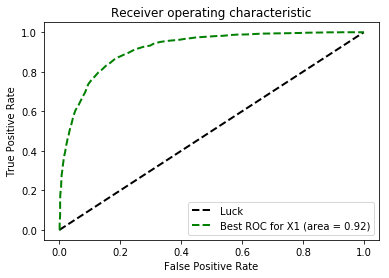

Now preparing to submit test set predictions to Kaggle.
We will retrain one last time using the best C value we found above, and
using ALL training data (100%) of the design matrix X1...

Now using our classifier to predict the sentiment label for each review in the corresponding test data...
Done predicting all sentiment labels. Outputting the predictions to X1_model.csv...
Finished!

    Training with X2...

Starting 5-fold cross-validation on the training set for X2 (repeating 15 times)...
Loop 0...C = 84
C, AUC: 84, 0.9076364012423802
Loop 1...C = 61
C, AUC: 61, 0.9048517976639271
Loop 2...C = 92
C, AUC: 92, 0.9095902854294896
Loop 3...C = 13
C, AUC: 13, 0.8587814761806977
Loop 4...C = 41
C, AUC: 41, 0.8981627283566204
Loop 5...C = 17
C, AUC: 17, 0.8716085302703032
Loop 6...C = 16
C, AUC: 16, 0.8679389303261849
Loop 7...C = 62
C, AUC: 62, 0.9057932288196713
Loop 8...C = 79
C, AUC: 79, 0.9088512938500651
Loop 9...C = 88
C, AUC: 88, 0.9092996609232289
Loop 10...C = 98
C, AUC: 98, 0.9

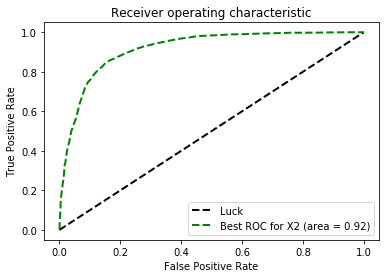

Now preparing to submit test set predictions to Kaggle.
We will retrain one last time using the best C value we found above, and
using ALL training data (100%) of the design matrix X2...

Now using our classifier to predict the sentiment label for each review in the corresponding test data...
Done predicting all sentiment labels. Outputting the predictions to X2_model.csv...
Finished!

    Training with X3...

Starting 5-fold cross-validation on the training set for X3 (repeating 15 times)...
Loop 0...C = 45
C, AUC: 45, 0.7968753733529284
Loop 1...C = 62
C, AUC: 62, 0.7985283204538566
Loop 2...C = 31
C, AUC: 31, 0.7939561180532281
Loop 3...C = 34
C, AUC: 34, 0.7950992490122232
Loop 4...C = 42
C, AUC: 42, 0.7966691117729663
Loop 5...C = 21
C, AUC: 21, 0.7868083431223366
Loop 6...C = 91
C, AUC: 91, 0.7997139400788751
Loop 7...C = 84
C, AUC: 84, 0.7988296208740143
Loop 8...C = 68
C, AUC: 68, 0.7980497075796583
Loop 9...C = 40
C, AUC: 40, 0.7934760292966309
Loop 10...C = 52
C, AUC: 52, 0.7

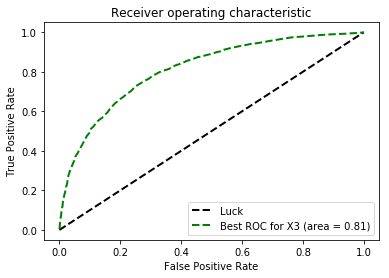

Now preparing to submit test set predictions to Kaggle.
We will retrain one last time using the best C value we found above, and
using ALL training data (100%) of the design matrix X3...

Now using our classifier to predict the sentiment label for each review in the corresponding test data...
Done predicting all sentiment labels. Outputting the predictions to X3_model.csv...
Finished!

    Training with X4...

Starting 5-fold cross-validation on the training set for X4 (repeating 15 times)...
Loop 0...C = 33
C, AUC: 33, 0.8118400497293494
Loop 1...C = 32
C, AUC: 32, 0.8117356151648089
Loop 2...C = 84
C, AUC: 84, 0.8201785020590138
Loop 3...C = 35
C, AUC: 35, 0.8138027120759228
Loop 4...C = 56
C, AUC: 56, 0.819034871838061
Loop 5...C = 19
C, AUC: 19, 0.8059402036331776
Loop 6...C = 34
C, AUC: 34, 0.8135786951763763
Loop 7...C = 15
C, AUC: 15, 0.801739347186195
Loop 8...C = 83
C, AUC: 83, 0.8215110167846928
Loop 9...C = 53
C, AUC: 53, 0.8164038455224681
Loop 10...C = 26
C, AUC: 26, 0.811

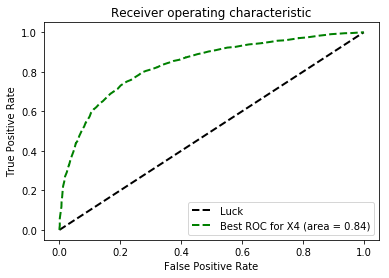

Now preparing to submit test set predictions to Kaggle.
We will retrain one last time using the best C value we found above, and
using ALL training data (100%) of the design matrix X4...

Now using our classifier to predict the sentiment label for each review in the corresponding test data...
Done predicting all sentiment labels. Outputting the predictions to X4_model.csv...
Finished!



In [39]:
np.random.seed(0)
lw = 2  # this is the line width that we will use for plotting

# Place into lists the 4 design matrices and corresponding Y (sentiment) vectors which we created in Section 2.
# We will iterate through these and train our model for each design matrix and gauge their performance
X_List = [X1, X2, X3, X4]
X_Str_List = ["X1", "X2", "X3", "X4"]
X_Test_List = [X1_test, X2_test, X3_test, X4_test]
Y_List = [Y, Y, Y, Y]

# The below 2 variables are parameters that will be fed into the invocation of get_test_data_features() method.
# test = None
# test_data_features = None

# Go thru each element in X_List and corresponding element in Y_List
for xi, yi in zip(range(len(X_List)), range(len(Y_List))):
    print("====================================================\n\
    Training with {}...\n====================================================\n".format(X_Str_List[xi])) # testing
    # Doing 80/20 split into training / test data
    X_train, X_test, Y_train, Y_test = train_test_split(X_List[xi], Y_List[yi], test_size=0.20, random_state = 0)
    best_performer = k_fold_randomforest_classification(X_train, Y_train, X_Str_List[xi])  # Call custom function
    best_mean_auc = best_performer[0]
    best_mean_fpr = best_performer[1]
    best_mean_tpr = best_performer[2]
    best_C = best_performer[-1]
    
    print ("\nRetraining the classifier using the entire learning set of {} with the best C value of {}...".format(
        X_Str_List[xi], best_C))
    
    classifier = RandomForestClassifier(n_estimators = best_C)
    probas_ = classifier.fit(X_train, Y_train).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print("Done retraining. C, AUC = {}, {}".format(best_C, roc_auc))
    print("\nPlotting the ROC-AUC curve...")
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
                 label='Luck')
    plt.plot(fpr, tpr, color='g', linestyle='--',
         label='Best ROC for {:} (area = {:.2f})'.format(X_Str_List[xi], roc_auc), lw=lw)

    # Set the range of x-axis and y-axis for graphing purposes.
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", fontsize=10)
    plt.show()
    
    print("Now preparing to submit test set predictions to Kaggle.")
    print("We will retrain one last time using the best C value we found above, and\n\
using ALL training data (100%) of the design matrix {}...".format(X_Str_List[xi]), end="")
    classifier = RandomForestClassifier(n_estimators = best_C)
    classifier = classifier.fit(X_train, Y_train)
    print("\n\nNow using our classifier to predict the sentiment label for each review in the corresponding test data...")
    result = classifier.predict(X_Test_List[xi])
    print("Done predicting all sentiment labels. Outputting the predictions to {}_model.csv...".format(X_Str_List[xi]))
    
    output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

    output.to_csv( "{}_model.csv".format(X_Str_List[xi]), index=False, quoting=3 )
    print("Finished!\n")

Below is the result of each model as submitted to Kaggle (If the image doesn't show below, refer to the file KAGGLE_submissions.png):

<img src="KAGGLE_submissions.png">

Out of the 4 models, model X1 gave the best accuracy results (0.83836 on Kaggle).

Overall, these classifiers underperformed in their predictive performance when compared to the simple bag-of-words model, which is implemented below (and resulted in an accuracy of ~84-85% on Kaggle, screenshot below).

For future experiments, we may try a few things to possibly improve performance of one or more of the classifiers:

* For X1 and/or X2, try varying the number of clusters.
* For X2 (which is derived from the Google Word2Vec model), try not filtering out any words from the pre-trained model. This will result in efficiency taking a hit; however, maintaining the original list of 3,000,000 words and their pre-trained relations may improve predictive performance due to better clustering.
* Use larger value of n_estimators (greater than 100) for the RandomForestClassifier. We used varying values from 10 to 100 for our experiments above, and it appears that larger values resulted in the the best performance for all four models.
* Vary the parameter n_topics for the LDA. In our experiments, we tried values of 10 and 20 for n_topics; however it is possible that smaller or larger values may work better, especially for a binary sentiment classification task such as ours.
* Try different representations of the corpus, e.g. TfidfVectorizer, etc.

In [40]:
# The below code is taken from https://github.com/wendykan/DeepLearningMovies/blob/master/BagOfWords.py
# with edited syntax,
# Puts out a bag of words prediction csv file, for comparison with the above models

import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

import re
import nltk

from bs4 import BeautifulSoup
from nltk.corpus import stopwords


def review_to_wordlist( review, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()
    #
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

train = pd.read_csv('labeledTrainData.tsv', header=0, \
                delimiter="\t", quoting=3)
test = pd.read_csv('testData.tsv', header=0, delimiter="\t", \
               quoting=3 )

#nltk.download()  # Download text data sets, including stop words

# Initialize an empty list to hold the clean reviews
clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list

print ("Cleaning and parsing the training set movie reviews...\n")
for i in range( 0, len(train["review"])):
    clean_train_reviews.append(" ".join(review_to_wordlist(train["review"][i], True)))


# ****** Create a bag of words from the training set
#
print ("Creating the bag of words...\n")


# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.
vectorizer = CountVectorizer(analyzer = "word",   \
                         tokenizer = None,    \
                         preprocessor = None, \
                         stop_words = None,   \
                         max_features = 5000)

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of
# strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an
# array
np.asarray(train_data_features)

# ******* Train a random forest using the bag of words
#
print ("Training the random forest (this may take a while)...")


# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100)

# Fit the forest to the training set, using the bag of words as
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit( train_data_features, train["sentiment"] )



# Create an empty list and append the clean reviews one by one
clean_test_reviews = []

print ("Cleaning and parsing the test set movie reviews...\n")
for i in range(0,len(test["review"])):
    clean_test_reviews.append(" ".join(review_to_wordlist(test["review"][i], True)))

# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(clean_test_reviews)
np.asarray(test_data_features)

# Use the random forest to make sentiment label predictions
print ("Predicting test labels...\n")
result = forest.predict(test_data_features)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )

# Use pandas to write the comma-separated output file
output.to_csv('Bag_of_Words_model.csv', index=False, quoting=3)
print ("Wrote results to Bag_of_Words_model.csv")

Cleaning and parsing the training set movie reviews...



D:\Program_Files_Nospace\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file D:\Program_Files_Nospace\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


Creating the bag of words...

Training the random forest (this may take a while)...
Cleaning and parsing the test set movie reviews...



D:\Program_Files_Nospace\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file D:\Program_Files_Nospace\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


Predicting test labels...

Wrote results to Bag_of_Words_model.csv


<img src="KAGGLE_submission_BOW.png">